# GENERAL OVERVIEW OF THE PROJECT

This project is one of the task for the ModECI/MDF outreachy intenship perequite for summer 2023 internship. it shows step-by-step tutorial on how to implement pytorch with MDF (Model Description Format). In this tutorial, i will be taking you through step-by-step tutorial of how i built a pytorch model, trained it and then converted it to MDF in order to use it with any MDF compatible tools.

# REQUIREMENT

The following libraries is what i used for building  this project.

1. Numpy: Numpy is a python library used for working with arrays. it also has functions for working in domain of linear Algebra, fourier tranform, and matrices.
2. torch: This is an open-source machine learning library, a scientific computing framework, and a script language based on the Lua programming language.
3. torchvision: This provides additional functionalities to manipulate and process images with standard image processing algorithms. Hence, the resulting images can be used directly with the Torch machine learning algorithms as Torchvision is fully integrated with Torch
4. torch.nn: This module contains different classes that help you build neural network models. 
5. torch.optim: This is a package implementing various optimization algoritms. 
6. torchsummary: This provides information complementary to what is provided by print(your_model) in pytorch, similar to Tensorflow's model. summary() API to view the visualization of the model, which is helpful while debugging your network.
7. torch.nn.fuctional: Applies a 2D convolution over an input image composed of several input planes.

# DATASET

The MNIST(Modified National Institute of Standards and Technology) dataset is a widely used dataset for machine learning and computer vision.  it consists of a large collection of grayscale images of handwritten digits(0-9), along with their corresponding labels (the digit in each image). Each image in the MNIST dataset is 28x28 pixels in size, and is represented as a 2-dimensional array of pixel intensities. The reason why we use MNIST to build this model is because of the following:

* Availability: The MNIST dataset is widely available and is easy to download. it can also be loaded directly from online.
* Simple and well-defined: The MNIST dataset consists of simple grayscale images of handwritten digits, and the task of classifying the digit in each image is well defined and straightforward.
* Low Dimension: The MNIST images are 28x28 pixels in size, which is a relatively low dimensional input space compared to more complex image datasets. This makes it easier to train machine learning models and to visualize the results.
* Clean and Preprocessed: The MNIST dataset has already been preprocessed and cleaned which saves time and reduces the amount of preprocessing required.

# WORKFLOW

1. I created a simple model with pytorch using the MNIST dataset which was later saved to be re-used in the next notebook.
2. The model was then loaded in the second notebook and the pytorch model was converted to MDF using the pytorch_to_mdf function in the MDF library.
3. In the last workflow of this project, the newly created MDF Model was then saved in the json and yaml file format and the graphical representation of it was generated.

### Importing the neccessary libraries

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
import numpy as np

### Loading the dataset

In [11]:
# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=torchvision.transforms.ToTensor(), 
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=torchvision.transforms.ToTensor(), 
                                          download=True)

### Defining the Model

In [12]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
  
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Instantiate the model

In [14]:
# Instantiate the model
model = Classifier()
  
# Move the model to the GPU if available
model.to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
         Dropout2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
         MaxPool2d-5             [-1, 64, 7, 7]               0
         Dropout2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
            Linear-8                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.43
Params size (MB): 1.61
Estimated Total Size (MB): 2.04
----------------------------------------------------------------


### Defining loss function and optimizer for the model 

In [15]:
# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training the model

In [16]:
batch_size=100
num_epochs=10
# Split the training set into training and validation sets
val_percent = 0.2 # percentage of the data used for validation
val_size    = int(val_percent * len(train_dataset))
train_size  = len(train_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, 
                                                           [train_size, 
                                                            val_size])
  
# Create DataLoaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=batch_size, 
                                         shuffle=False,
                                         pin_memory=True)
losses = []
accuracies = []
val_losses = []
val_accuracies = []
# Train the model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        images=images.to(device)
        labels=labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
          
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
        _, predicted = torch.max(outputs.data, 1)
    acc = (predicted == labels).sum().item() / labels.size(0)
    accuracies.append(acc)
    losses.append(loss.item())  
          
    # Evaluate the model on the validation set
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            labels=labels.to(device)
            images=images.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
              
            _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        val_acc += correct / total
        val_accuracies.append(acc)
        val_losses.append(loss.item())  
      
              
    print('Epoch [{}/{}],Loss:{:.4f},Validation Loss:{:.4f},Accuracy:{:.2f},Validation Accuracy:{:.2f}'.format(
        epoch+1, num_epochs, loss.item(), val_loss, acc , val_loss, acc ,val_acc))

Epoch [1/10],Loss:0.1718,Validation Loss:16.7794,Accuracy:0.95,Validation Accuracy:16.78
Epoch [2/10],Loss:0.0657,Validation Loss:10.8253,Accuracy:0.99,Validation Accuracy:10.83
Epoch [3/10],Loss:0.0287,Validation Loss:7.9814,Accuracy:0.97,Validation Accuracy:7.98
Epoch [4/10],Loss:0.0253,Validation Loss:8.4631,Accuracy:0.97,Validation Accuracy:8.46
Epoch [5/10],Loss:0.0350,Validation Loss:7.4562,Accuracy:0.99,Validation Accuracy:7.46
Epoch [6/10],Loss:0.0156,Validation Loss:8.5553,Accuracy:0.99,Validation Accuracy:8.56
Epoch [7/10],Loss:0.0098,Validation Loss:6.1927,Accuracy:0.98,Validation Accuracy:6.19
Epoch [8/10],Loss:0.0174,Validation Loss:6.5545,Accuracy:0.98,Validation Accuracy:6.55
Epoch [9/10],Loss:0.0143,Validation Loss:5.6700,Accuracy:0.98,Validation Accuracy:5.67
Epoch [10/10],Loss:0.0141,Validation Loss:5.8334,Accuracy:1.00,Validation Accuracy:5.83


### Plotting the training and validation loss graph

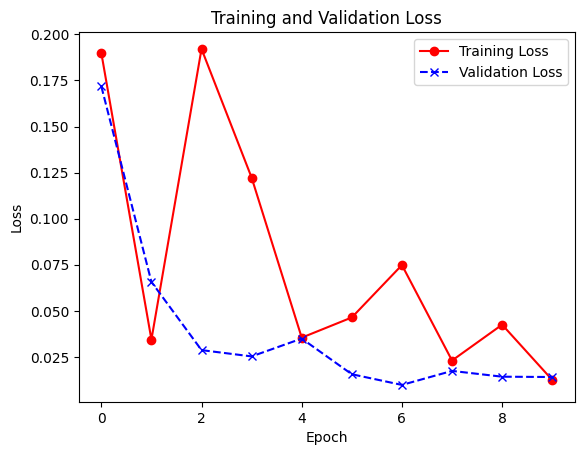

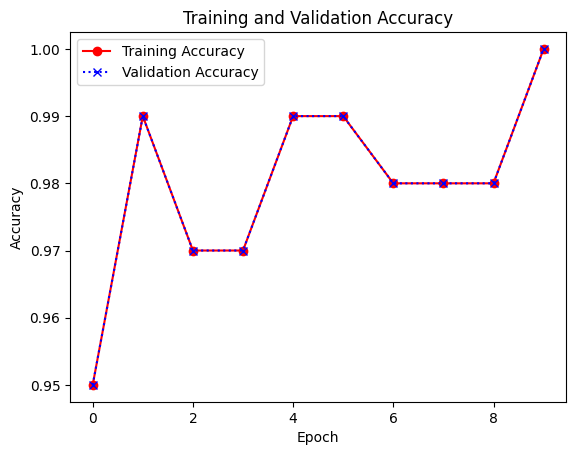

In [18]:
import matplotlib.pyplot as plt
  
# Plot the training and validation loss over time
plt.plot(range(num_epochs), 
         losses, color='red', 
         label='Training Loss',
         marker='o')
plt.plot(range(num_epochs), 
         val_losses,
         color='blue', 
         linestyle='--', 
         label='Validation Loss', 
         marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
  
# Plot the training and validation accuracy over time
plt.plot(range(num_epochs), 
         accuracies, 
         label='Training Accuracy', 
         color='red', 
         marker='o')
plt.plot(range(num_epochs), 
         val_accuracies, 
         label='Validation Accuracy', 
         color='blue', 
         linestyle=':', 
         marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Evaluating the model

In [25]:
#Create a DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
  
# Evaluate the model on the test dataset
model.eval()
  
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted=predicted.to('cpu')
        labels=labels.to('cpu')
        y_true.extend(labels)
        y_pred.extend(predicted)
  
print('Test Accuracy: {}%'.format(100 * correct / total))
  
 #Generate a classification report
  
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

Test Accuracy: 99.16%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### Making prediction with the model

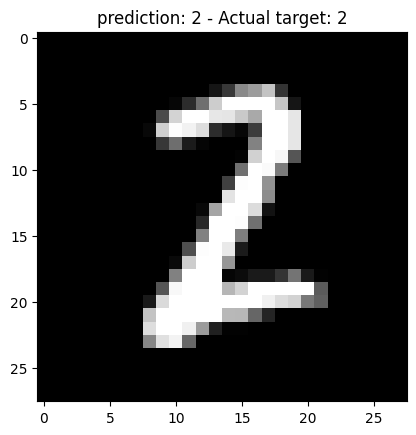

In [29]:
with torch.no_grad():
    index = 256
    item = test_dataset[index]
    image = item[0]
    true_target = item[1]
    
    prediction = model(image)
    predicted_class = np.argmax(prediction)
    image = image.reshape(28, 28, 1)
    plt.imshow(image, cmap = 'gray')
    plt.title(f'prediction: {predicted_class} - Actual target: {true_target}')
    plt.show()

### Saving the model

In [31]:
#save the model
PATH = 'pytorch_model.pt'
torch.save(model.state_dict(), PATH)